# The One Dimensional Heat Equation - Implicit Schemes

In [1]:
from sympy import *
from sympy.utilities.lambdify import lambdify
init_printing()

## The one dimensional heat conduction

If $u(x,t)$ is the temperature at position $x$ and time t the one dimensional heat equation is given by:


In [2]:
x = Symbol('x')
t = Symbol('t')
u = Function('u')(x,t)
heat = Eq(u.diff(t),u.diff(x,x))
pprint(heat)

                2         
∂              ∂          
──(u(x, t)) = ───(u(x, t))
∂t              2         
              ∂x          


In the lectures, we have found the particular solution

In [3]:
k = Symbol('k')
u_part = exp(-(k*pi)**2*t)*sin(k*pi*x)
pprint(u_part)

   2  2             
 -π ⋅k ⋅t           
ℯ        ⋅sin(π⋅k⋅x)


if $k$ is an integar,

In [4]:
u_part = u_part.subs(k,1)
pprint(u_part)

   2           
 -π ⋅t         
ℯ     ⋅sin(π⋅x)


we can see that u_part satifies the heat equation

In [5]:
heat = heat.subs(u,u_part)
pprint(heat.doit())

True


and the following boundary conditions:

In [6]:
u_0 = u_part.subs(x,0)
u_1 = u_part.subs(x,1)
print("u_0 = " + pretty(u_0))
print("u_1 = " + pretty(u_1))

u_0 = 0
u_1 = 0


and initial conditions:

In [7]:
u_init = u_part.subs(t,0)
print("u_init = " + pretty(u_init))

u_init = sin(π⋅x)


And here's a 3D-plot of the solution

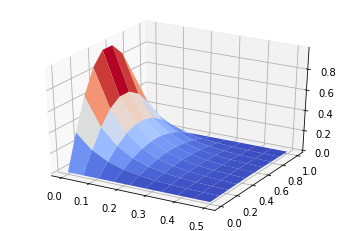

<Figure size 432x288 with 0 Axes>

In [8]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm

lam_u_part = lambdify((x,t), u_part)
Nx = 10
Nt = 10
xa = np.linspace(0,1,Nx) 
ta = np.linspace(0,0.5,Nt)
X, T = np.meshgrid(xa, ta)
Q = np.asarray([[lam_u_part(Xe,Te) for (Xe, Te) in zip(Xrow,Trow)] for (Xrow,Trow) in zip(X,T)])
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(T, X, Q, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0, antialiased=True)
fig = plt.figure()

## Numerical solution using an implicit scheme

Similar to the explicit scheme, we need to define the number of unknowns, the mesh size, and
the size and number of the time steps:

In [9]:
n = 20; h = 1./n
tau = 1./8; steps = 2
v = np.zeros((n+1,steps+1))

Then, we initialize our numerical solution:

In [10]:
lam_u_init = lambdify(x,u_init)
for j in range(1,n):
    v[j,0] = lam_u_init(j*h)

and set the boundary conditions:

In [11]:
for m in range(0,steps+1):
    v[0,m] = 0
    v[n,m] = 0

Now, before we can start to compute the numerical solution, we need to set up the iteration matrix.

In [12]:
from scipy import sparse
#tridiag = sparse.diags([-1,2,-1],[-1,0,1],shape=(n-1,n-1))
data0 = [-1 for i in range(0,n)]
data1 = [2 for i in range(0,n)]
data2 = [-1 for i in range(0,n)]
data = [data0, data1, data2]
diags = [-1, 0, 1]
#tridiag = sparse.spdiags(data,diags,n-1,n-1)
M = sparse.identity(n-1) + (tau/h**2)*sparse.spdiags(data,diags,n-1,n-1)

Now, we compute the numerical solution

In [13]:
from scipy.sparse import linalg
v[1:n,0]=linalg.spsolve(M,v[1:n,0])

We may take a little time to plot the results:

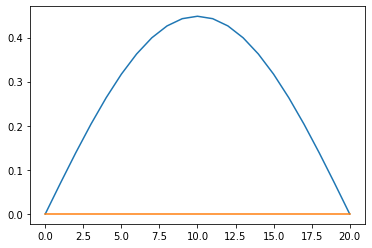

In [14]:
plt.figure()
plt.plot(v[:,0])
plt.plot(v[:,1])
plt.show()

To compute the solution for all time steps, we use the following loop:

In [15]:
for m in range(0,steps):
    v[1:n,m+1]=linalg.spsolve(M,v[1:n,m])

And plot the results again:

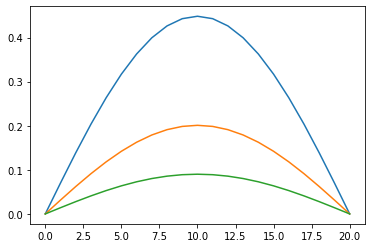

In [16]:
plt.figure()
for m in range(0,steps+1):
    plt.plot(v[:,m])
plt.show()

Of course, we would like to compare the numerical solution with the anayltic one. The following
plot shows, that we can come pretty close ...

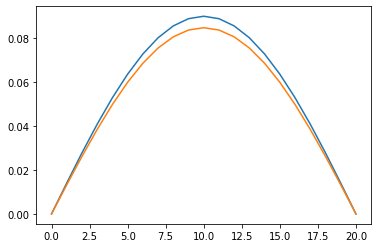

In [17]:
exact_plot = [lam_u_part(j*h,steps*tau) for j in range(0,n+1)]
plt.figure()
plt.plot(v[:,steps])
plt.plot(exact_plot)
plt.show()

## A Second Order Implicit Scheme

In [18]:
n = 20; h = 1./n
tau = 1./40; steps = 10
v = np.zeros((n+1,steps+1))

Then, we initialize our numerical solution:

In [19]:
lam_u_init = lambdify(x,u_init)
for j in range(1,n):
    v[j,0] = lam_u_init(j*h)

and set the boundary conditions:

In [20]:
for m in range(0,steps+1):
    v[0,m] = 0
    v[n,m] = 0

The iteration matrix is similar to that of the simple implicit scheme

In [21]:
data0 = [-1 for i in range(0,n)]
data1 = [2 for i in range(0,n)]
data2 = [-1 for i in range(0,n)]
data = [data0, data1, data2]
diags = [-1, 0, 1]
A = sparse.spdiags(data,diags,n-1,n-1)

However, we require an additional weighting parameter $\alpha$:

In [22]:
alpha = 0.5
M = sparse.identity(n-1) + alpha*(tau/h**2)*A

To compute the solution for all time steps, we use the following loop:

In [23]:
for m in range(0,steps):
    v[1:n,m+1]=linalg.spsolve(M,np.array([v[j,m]+(1-alpha)*(tau/h**2)*(v[j-1,m] - 2*v[j,m] + v[j+1,m]) for j in range(1,n)]))

And plot the results again:

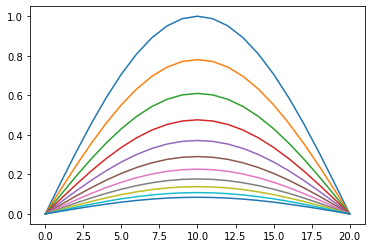

In [24]:
plt.figure()
for m in range(0,steps+1):
    plt.plot(v[:,m])
plt.show()

Of course, we would like to compare the numerical solution with the anayltic one. The following
plot shows, that we can come pretty close ...

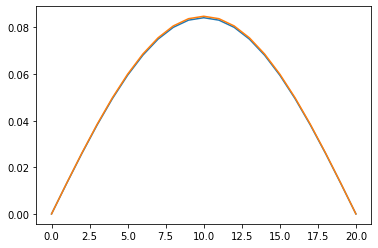

In [25]:
exact_plot = [lam_u_part(j*h,steps*tau) for j in range(0,n+1)]
plt.figure()
plt.plot(v[:,steps])
plt.plot(exact_plot)
plt.show()